# Модель классификации в банковском скоринге

### Инициализация проекта. Стэк

In [2]:
!pip install pandas scikit-learn seaborn matplotlib numpy xgboost # Заглушка

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

# Новая эра Предикта
from xgboost import XGBClassifier


In [4]:
df_train = pd.read_csv('datasets/train.csv', low_memory=False)

### Train и Test
#### Описание по столбцам:
> __ID__ - Представляет собой уникальную идентификацию записи

> __Customer_ID__ - Представляет собой уникальную идентификацию человека. *Потенциально полезен, но в производстве, потому что один человек имеет несколько записей в датасете*

> __Month__ - Обозначает месяц в году

> __Name__ - Имя человека

> __Age__ - Возраст человека

> __SSN__ - Представляет собой номер социального страхования человека

> __Occupation__ - Отражает род занятий этого человека

> __Annual_Income__ - Представляет собой годовой доход данного лица

> __Monthly_Inhand_Salary__ - Представляет собой месячную базовую заработную плату сотрудника

> __Num_Bank_Accounts__ - Представляет собой количество банковских счетов, которыми владеет человек

> __Num_Credit_Card__ - Представляет собой количество других кредитных карт, имеющихся у данного лица

> __Interest_Rate__ - Представляет собой процентную ставку по кредитной карте

> __Num_of_Loan__ - Представляет собой количество кредитов, взятых в банке

> __Type_of_Loan__ - Представляет виды займов, взятых человеком

> __Delay_from_due_date__ - Представляет собой среднее количество дней задержки с даты платежа

> __Num_of_Delayed_Payment__ - Представляет собой среднее количество платежей, задержанных одним лицом

> __Changed_Credit_Limit__ - Представляет собой процентное изменение лимита кредитной карты

> __Num_Credit_Inquiries__ - Представляет собой количество запросов по кредитным картам

> __Credit_Mix__ - Представляет собой классификацию набора кредитов

> __Outstanding_Debt__ - Представляет собой оставшуюся задолженность, подлежащую выплате (в долларах США).

> __Credit_Utilization_Ratio__ - Представляет собой коэффициент использования кредитной карты

> __Credit_History_Age__ - Отражает возраст кредитной истории данного лица

> __Payment_of_Min_Amount__ - Отражает, была ли выплачена лицом только минимальная сумма

> __Total_EMI_per_month__ - Представляет собой ежемесячные платежи EMI (в долларах США).

> __Amount_invested_monthly__ - Представляет собой ежемесячную сумму, инвестированную клиентом (в долларах США).

> __Payment_Behaviour__ - Отражает платежное поведение клиента (в долларах США).

> __Monthly_Balance__ - Представляет собой сумму ежемесячного баланса клиента (в долларах США).

> __Credit_Score__ - Представляет собой шкалу кредитного рейтинга (Poor, Standart, Good). Отсутствует в Test.csv
    

In [5]:
df_train_v1 = df_train.copy() # Датасет первого этапа
df_train_v2 = df_train.copy() # Датасет второго этапа

In [6]:
# Пересечение
# common_customers = set(df_train['Customer_ID']).intersection(set(df_test['Customer_ID']))
# print(f"Количество клиентов, встречающихся и в train, и в test: {len(common_customers)}")
# 
# 
# print("Примеры общих Customer_ID:", list(common_customers)[:5])

In [7]:
# Проверим, сколько клиентов встречается и в train, и в test
# common_customers = set(df_train['Customer_ID']).intersection(set(df_test['Customer_ID']))
# print(f"Общих клиентов: {len(common_customers)}")
# 
# test_common_rows = df_test[df_test['Customer_ID'].isin(common_customers)]
# print(f"Строк в test, относящихся к общим клиентам: {len(test_common_rows)}")

In [8]:
print("Train shape:", df_train_v1.shape)

Train shape: (100000, 28)


In [9]:
df_train_v1.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


#### Видим, что данные в датасете "грязные" - есть пропуски, поэтому и пришлось использовать low_memory

In [10]:
df_train_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

#### Делаем анализ и понимаем, что некоторые колонки являются мусорными
 К тому же есть много пропусков, что сильно портит наш датасет, ведь нам нужны числовые данные, а из-за пропусков получается object

### Pre-processing 1

In [11]:
# Функция для Preprocessing двух датасетов. Второй будет дополнительно обработан во 2 этапе
def convert_credit_history(age_str):
        if pd.isna(age_str):
            return np.nan
        years = int(age_str.split()[0])
        months = int(age_str.split()[3])
        return years * 12 + months

def base_clean_df(df):
    drop_cols = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
    df = df.drop(columns=drop_cols)
    # Сделаем числовые значения great again, в смысле, снова числовыми, а не object

    num_cols = [
        'Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
        'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'
    ]
    
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce') # Благодаря coerce разделяем записи на НАШИХ и "неправильно мыслящих", все должны мыслить числами!
    
    
    
    df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_history)
    
    # ЗАМЕНА АНОМАЛЬНЫХ ЗНАЧЕНИЙ 
    
    # Удалим МЕГАааа, значения: <18 или >109
    df.loc[(df['Age'] < 18) | (df['Age'] > 109), 'Age'] = np.nan # Под старость лет дед купил танк в кредит и отомстил соседу за украденные 20 см участка
    df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', np.nan)
    df['Occupation'] = df['Occupation'].replace('_______', np.nan)
    df.loc[df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan
    df.loc[df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = np.nan
    
    return df
    


После такого плотного преобразования смотрим результат

In [12]:
df_train_v1 = base_clean_df(df_train_v1)

In [14]:
df_train_v1 = df_train_v1.drop('Interest_Rate', axis=1)

In [15]:
df_train_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       86939 non-null   float64
 1   Occupation                92938 non-null   object 
 2   Annual_Income             93020 non-null   float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Num_of_Loan               95215 non-null   float64
 7   Type_of_Loan              88592 non-null   object 
 8   Delay_from_due_date       99409 non-null   float64
 9   Num_of_Delayed_Payment    89632 non-null   float64
 10  Changed_Credit_Limit      97909 non-null   float64
 11  Num_Credit_Inquiries      98035 non-null   float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          98991 non-null   fl

#### Видим, что как-то странно получается Age 

In [16]:
df_train_v1

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3,4,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,...,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23.0,Scientist,19114.12,NaN,3,4,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,NaN,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,NaN,Scientist,19114.12,NaN,3,4,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,7.0,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,23.0,Scientist,19114.12,NaN,3,4,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5.0,4.0,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,23.0,Scientist,19114.12,1824.843333,3,4,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6.0,NaN,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25.0,Mechanic,39628.99,3359.415833,4,6,2.0,"Auto Loan, and Student Loan",23.0,7.0,...,_,502.38,34.663572,378.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
99996,25.0,Mechanic,39628.99,3359.415833,4,6,2.0,"Auto Loan, and Student Loan",18.0,7.0,...,_,502.38,40.565631,379.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
99997,25.0,Mechanic,39628.99,3359.415833,4,6,2.0,"Auto Loan, and Student Loan",27.0,6.0,...,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,25.0,Mechanic,39628.99,3359.415833,4,6,2.0,"Auto Loan, and Student Loan",20.0,NaN,...,Good,502.38,33.638208,381.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


In [17]:
# print("Уникальные значения Payment_Behaviour:")
# print(df_train['Payment_Behaviour'].value_counts().head(10))

In [85]:
# print("Уникальные значения Payment_of_Min_Amount:")
# print(df_train['Payment_of_Min_Amount'].value_counts())

Уникальные значения Payment_of_Min_Amount:
Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64


In [86]:
# print("Уникальные значения Occupation:")
# print(df_train['Occupation'].value_counts().head(10))

Уникальные значения Occupation:
Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Name: count, dtype: int64


In [88]:
# print("Уникальные значения Interest_Rate:")
# print(df_train['Interest_Rate'].value_counts())

Уникальные значения Interest_Rate:
Interest_Rate
8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
3085       1
159        1
375        1
3177       1
3032       1
Name: count, Length: 1750, dtype: int64


Чё-то фигня полная, я бы не брал такой кредит

In [91]:
# print("Уникальные значения Delay_from_due_date:")
# print(df_train['Delay_from_due_date'].value_counts())

Уникальные значения Delay_from_due_date:
Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64


Ну странно отрицательные дни просрочки, коррупция

### EDA

Проверяем чистку по возрасту

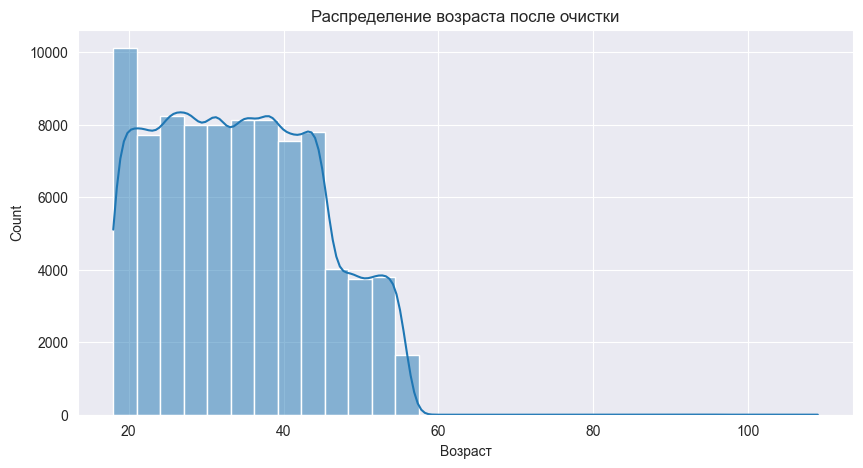

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train_v1['Age'], bins=30, kde=True)
plt.title('Распределение возраста после очистки')
plt.xlabel('Возраст')
plt.show()

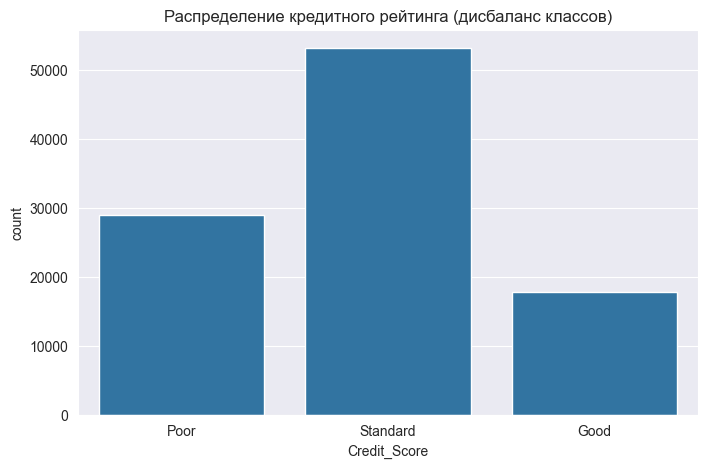

Credit_Score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64


In [142]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train_v1, x='Credit_Score', order=['Poor', 'Standard', 'Good'])
plt.title('Распределение кредитного рейтинга (дисбаланс классов)')
plt.show()

print(df_train_v1['Credit_Score'].value_counts(normalize=True))

Классы кривые, Standart выделяется на фоне остальных

Это означает, что модель может запоминать наиболее частый класс, а не учиться обобщённым закономерностям.

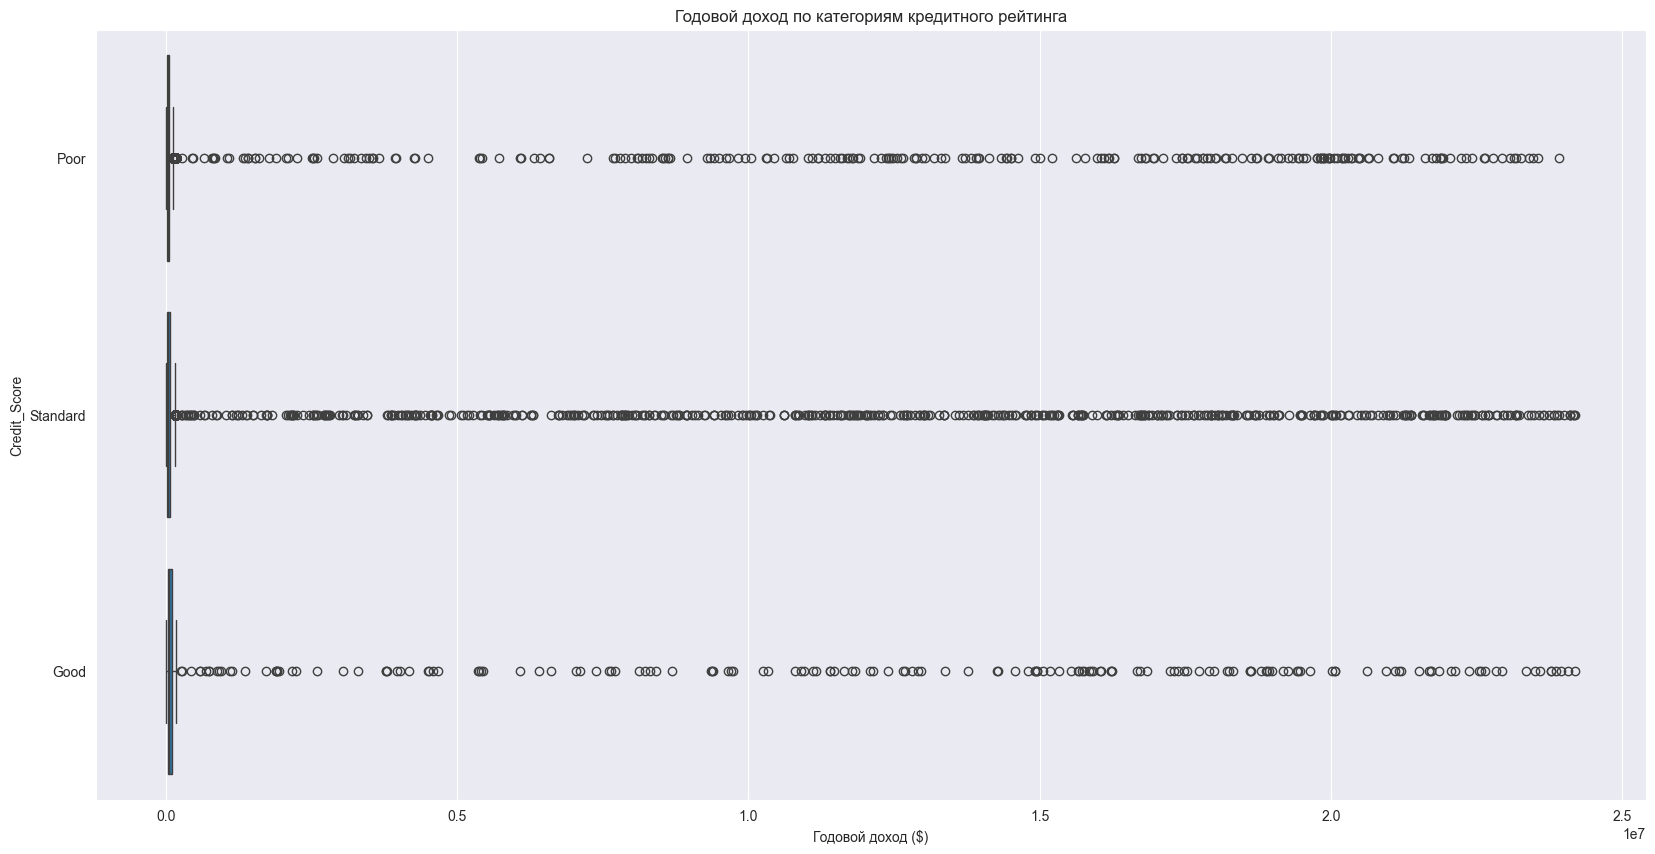

In [143]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_train_v1, x='Annual_Income', y='Credit_Score', order=['Poor', 'Standard', 'Good'])
plt.title('Годовой доход по категориям кредитного рейтинга')
plt.xlabel('Годовой доход ($)')
plt.show()

In [23]:
df_encoded = df_train_v2.copy()
le = LabelEncoder()
df_encoded['Credit_Score_Encoded'] = le.fit_transform(df_encoded['Credit_Score'])

In [24]:
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

numeric_cols = [col for col in numeric_cols if col != 'Credit_Score']

cols_for_corr = numeric_cols + ['Credit_Score_Encoded']

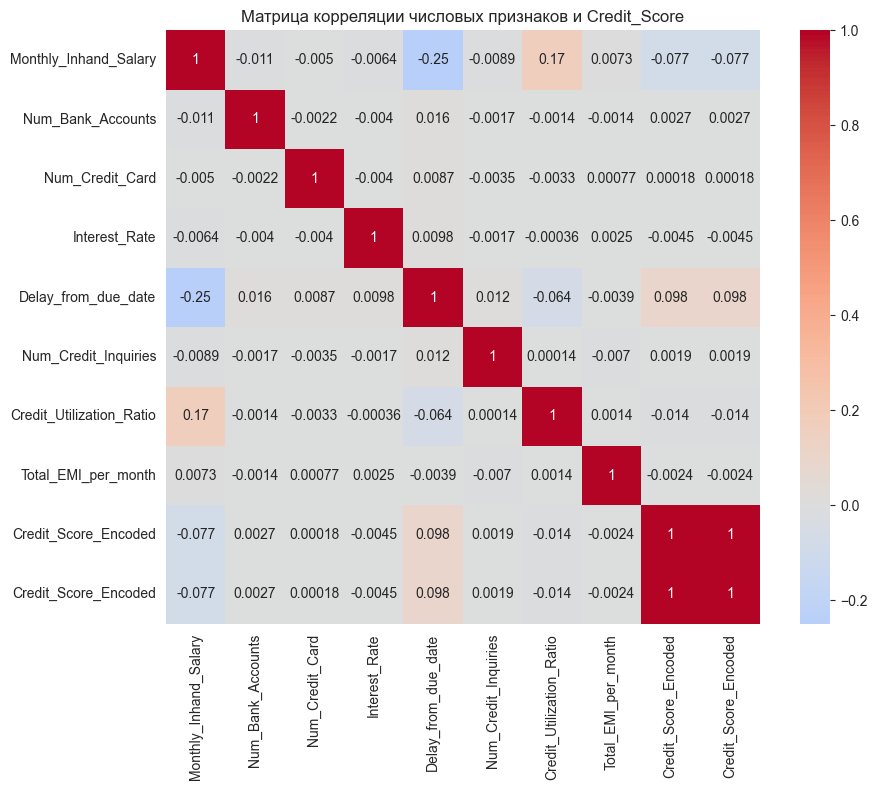

In [28]:
# Матрица корреляции (метод Пирсона)
corr_matrix = df_encoded[cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True
)
plt.title('Матрица корреляции числовых признаков и Credit_Score')
plt.tight_layout()
plt.show()

## Baseline-model
Наконец-то Baseline и пайплайны

In [144]:
# Разделение исходного df_train
X = df_train_v1.drop(columns=['Credit_Score'])
y = df_train_v1['Credit_Score']

X_train_inner, X_val, y_train_inner, y_val = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print(f"Train inner: {X_train_inner.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")

Train inner: 70000 samples
Validation: 30000 samples


#### "Грязный" preprocessing

In [145]:
num_features = X_train_inner.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train_inner.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), cat_features)
    ]
)

На самом деле я специально поставил Логистическую регрессию, знаю, что она хуже, просто так получится понаблюдать за улучшениями, и это далеко не всё.

Сейчас всё супер грязное, модель, данные, ну, понятно в общем

In [146]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Обучение
baseline_pipeline.fit(X_train_inner, y_train_inner)

y_pred_baseline = baseline_pipeline.predict(X_val)

# Метрики
f1_baseline = f1_score(y_val, y_pred_baseline, average='macro')
print(f"Baseline (LogisticRegression) F1-macro: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_baseline))

C:\Users\Qweeck\PycharmProjects\ml-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline (LogisticRegression) F1-macro: 0.5382

Classification Report:
              precision    recall  f1-score   support

        Good       0.51      0.35      0.41      5349
        Poor       0.63      0.44      0.52      8699
    Standard       0.61      0.78      0.69     15952

    accuracy                           0.60     30000
   macro avg       0.58      0.52      0.54     30000
weighted avg       0.60      0.60      0.59     30000



Как видим из наших метрик, Великому Предикту не понравились наши датасеты

In [67]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Обучение
rf_pipeline.fit(X_train_inner, y_train_inner)

y_pred_rf = rf_pipeline.predict(X_val)

# Метрики
f1_rf = f1_score(y_val, y_pred_rf, average='macro')
print(f"Random Forest F1-macro: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

Random Forest F1-macro: 0.7633

Classification Report:
              precision    recall  f1-score   support

        Good       0.72      0.70      0.71      5349
        Poor       0.77      0.78      0.78      8699
    Standard       0.80      0.80      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.76      0.76      0.76     30000
weighted avg       0.78      0.78      0.78     30000



#### Результаты ожидаемы, __Великий Предикт__ посмотрел на наши данные со стороны Random Forest и ему уже они больше нравятся

> Посмотрим какие ему больше нравятся

In [102]:
# получаем модель и смотрим на её важности)
rf_model = rf_pipeline.named_steps['classifier'] 
importances = rf_model.feature_importances_

feature_names = num_features + cat_features 

feat_imp = pd.DataFrame({ # В датафрейме удобнее смотреть
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp) 

                     feature  importance
10          Outstanding_Debt    0.126716
6        Delay_from_due_date    0.072437
8       Changed_Credit_Limit    0.064455
12        Credit_History_Age    0.064051
18                Credit_Mix    0.062765
15           Monthly_Balance    0.049828
11  Credit_Utilization_Ratio    0.048793
14   Amount_invested_monthly    0.048510
9       Num_Credit_Inquiries    0.048126
4            Num_Credit_Card    0.047881
1              Annual_Income    0.046348
13       Total_EMI_per_month    0.045924
2      Monthly_Inhand_Salary    0.043440
17              Type_of_Loan    0.042588
3          Num_Bank_Accounts    0.039210
0                        Age    0.038895
16                Occupation    0.031601
5                Num_of_Loan    0.029229
19     Payment_of_Min_Amount    0.028340
20         Payment_Behaviour    0.020362
7     Num_of_Delayed_Payment    0.000503


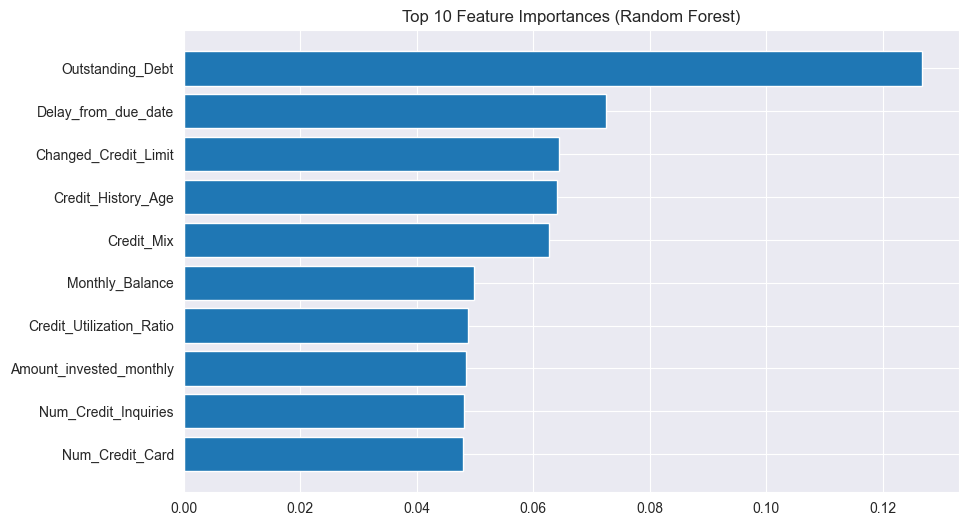

In [103]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:10], feat_imp['importance'][:10]) # топ 10
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

Мой вывод таков, что модель хорошо поняла по каким признаком определяется кредитный рейтинг клиента. 

Кстати этим графиком можно объяснить в целом заёмщику, почему ему не дали кредит

### Интерпретация по топ 5 фичей:
> Outstanding_Debt (12.7%) - текущая задолженность.
> 
> Логично: чем больше долг, тем выше риск => хуже рейтинг.

> Delay_from_due_date (7.2%) - на сколько дней просрочка.
> 
> Прямой маркер финансовой дисциплины.


> Changed_Credit_Limit (6.4%) - изменение кредитного лимита.
> 
> Банки снижают лимит у рискованных клиентов.


> Credit_History_Age (6.4%) - возраст кредитной истории.
> 
> Долгая история = больше доверия.

> Credit_Mix (6.3%) - разнообразие типов кредитов.
> 
> Хороший микс (ипотека + карта + автокредит) = зрелость заемщика.

In [105]:
# Работа над ошибками
errors_mask = (y_val.values != y_pred_rf)
error_positions = np.where(errors_mask)[0][:5]  # первые 5 ошибок

if len(error_positions) > 0:
    sample_errors = X_val.iloc[error_positions].copy()
    sample_errors['Credit_Score_True'] = y_val.iloc[error_positions].values
    sample_errors['Credit_Score_Pred'] = y_pred_rf[error_positions]
    print(sample_errors[['Annual_Income', 'Outstanding_Debt', 'Credit_History_Age',
                        'Credit_Score_True', 'Credit_Score_Pred']])
else:
    print("Ошибок не найдено!")

       Annual_Income  Outstanding_Debt  Credit_History_Age Credit_Score_True  \
68811      157814.32            411.89               390.0              Good   
11284       76353.40            752.66               368.0          Standard   
7           19114.12            809.98                 NaN          Standard   
26959      104616.90           1417.84                 NaN              Poor   
39436       36137.59           1261.71               330.0              Good   

      Credit_Score_Pred  
68811          Standard  
11284              Good  
7                  Good  
26959          Standard  
39436          Standard  


Ошибки в основном такие:
1. Пропуски в Credit_History_Age приводят к ошибкам: модель не понимает как оценить клиента, плюс генерация данных может навредить человеку без этих данных. Есть вариант просто добавить фичу бинарную (is_new_customer)
2. Дисбаланс признаков: модель иногда игнорирует доход в пользу истории (или наоборот). Может помочь sample_weight или class_weight='balanced'. Есть ещё Oversampling/Undersampling, но есть свои моменты
3. Консерватизм модели: надёжные клиенты (Good) часто "занижаются" до Standard. Можно добавить ещё одну фичу dept to income ratio, чтобы было соотношение

Думаю неплохим решением будет сделать это во 2 главе улучшений

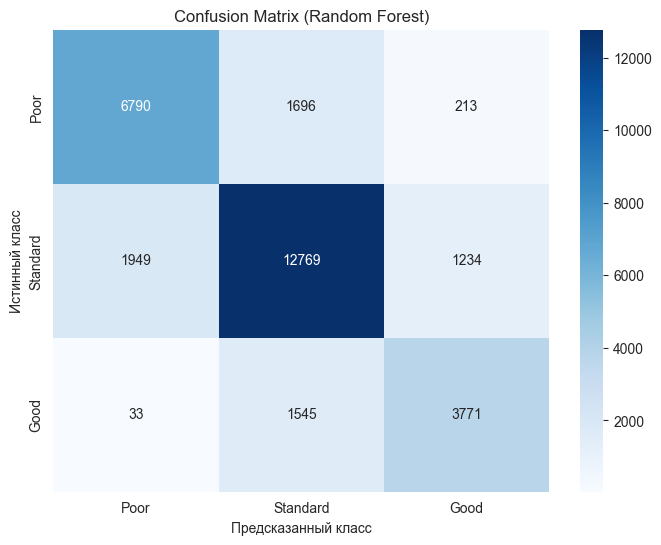

In [106]:
cm = confusion_matrix(y_val, y_pred_rf, labels=['Poor', 'Standard', 'Good'])

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Poor', 'Standard', 'Good'],
            yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

Как мы видим по матрице, лучше всего предсказывается standard, оно и понятно, дисбаланс классов.

Ранее мы выяснили, что standard частый класс в нашем датасете, следовательно, модель его запоминает. 

Технически это ошибка и можно улучшить результат

### 2 Этап. Улучшение улучшений

#### Мы уже сделали сделали базовый препроцессинг данных, провели EDA, построили модели и изучили их результаты с разными методами классификации

#### Теперь на основе всех этих данных можно попробовать реализовать 2 этап, который возможно не сильно, но улучшит наши результаты. Главное, чтобы не ухудшил из-за импутирования


 > ##### Вообще, в датасете с Kaggle по кредитному скорингу есть один момент, там всего несколько клиентов, 
 > 
 > ##### просто каждый имеет несколько записей, в более качественном анализе и обучении имело бы смысл отсортировать по Customer_ID, 
 > 
 > ##### в реальном банке это было бы, в каком-то смысле, ключевым моментом

### Чистка
Мы уже почистили Age, Occupation, Delay_from_due_date, Num_of_Delayed_Payment, Payment_Behaviour, Credit_History_Age и ещё 5 фичей без силы Предикта

Теперь проверим остальные и тоже подменим значения

In [166]:
df_train_v2 = base_clean_df(df_train_v2)

In [170]:
print("Уникальные значения Num_of_Loan:")
print(df_train['Num_of_Loan'].value_counts().head(20))

Уникальные значения Num_of_Loan:
Num_of_Loan
3       14386
2       14250
4       14016
0       10380
1       10083
6        7405
7        6930
5        6865
-100     3876
9        3542
8        3035
2_        782
4_        727
3_        718
0_        550
1_        523
7_        414
6_        398
5_        332
9_        160
Name: count, dtype: int64


In [171]:
# Улучшенная очистка данных, ставим плотные лимиты, больно, но реалистично
def advanced_clean_df(df): 
    df = df.copy()  # можно не менять оригинал, ну это bp
    
    df.loc[(df['Num_Bank_Accounts'] < 0) | (df['Num_Bank_Accounts'] > 20), 'Num_Bank_Accounts'] = np.nan
    
    df.loc[(df['Interest_Rate'] < 0) | (df['Interest_Rate'] > 36), 'Interest_Rate'] = np.nan

    df.loc[(df['Num_Credit_Card'] < 0) | (df['Num_Credit_Card'] > 10), 'Num_Credit_Card'] = np.nan

    df.loc[(df['Num_of_Loan'] < 0) | (df['Num_of_Loan'] > 10), 'Num_of_Loan'] = np.nan

    df.loc[(df['Annual_Income'] <= 1200) | (df['Annual_Income'] > 10_000_000), 'Annual_Income'] = np.nan

    df.loc[(df['Monthly_Inhand_Salary'] <= 100) | (df['Monthly_Inhand_Salary'] > 500_000), 'Monthly_Inhand_Salary'] = np.nan

    df.loc[(df['Delay_from_due_date'] < 0) | (df['Delay_from_due_date'] > 100), 'Delay_from_due_date'] = np.nan

    df.loc[(df['Num_of_Delayed_Payment'] < 0) | (df['Num_of_Delayed_Payment'] > 50), 'Num_of_Delayed_Payment'] = np.nan

    df.loc[(df['Changed_Credit_Limit'] < -100) | (df['Changed_Credit_Limit'] > 100), 'Changed_Credit_Limit'] = np.nan

    df.loc[(df['Num_Credit_Inquiries'] < 0) | (df['Num_Credit_Inquiries'] > 20), 'Num_Credit_Inquiries'] = np.nan

    df.loc[(df['Outstanding_Debt'] < 0) | (df['Outstanding_Debt'] > 10_000_000), 'Outstanding_Debt'] = np.nan

    df.loc[(df['Credit_Utilization_Ratio'] < 0) | (df['Credit_Utilization_Ratio'] > 100), 'Credit_Utilization_Ratio'] = np.nan

    df.loc[(df['Credit_History_Age'] < 0) | (df['Credit_History_Age'] > 600), 'Credit_History_Age'] = np.nan

    df.loc[(df['Total_EMI_per_month'] < 0) | (df['Total_EMI_per_month'] > 1_000_000), 'Total_EMI_per_month'] = np.nan

    df.loc[(df['Amount_invested_monthly'] < 0) | (df['Amount_invested_monthly'] > 1_000_000), 'Amount_invested_monthly'] = np.nan

    df.loc[(df['Monthly_Balance'] < 0) | (df['Monthly_Balance'] > 10_000_000), 'Monthly_Balance'] = np.nan
    
    return df 

Есть просто бешеная идея, разбить Type_of_Loan на отдельный фичи, только появится столько нулей, что использовать логистическую регрессию будет невозможно из-за разряжённости датасета, но RF и XGBoost должны схавать, наверное

In [169]:
df_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       86939 non-null   float64
 1   Occupation                92938 non-null   object 
 2   Annual_Income             93020 non-null   float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               95215 non-null   float64
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       99409 non-null   float64
 10  Num_of_Delayed_Payment    89632 non-null   float64
 11  Changed_Credit_Limit      97909 non-null   float64
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

In [172]:
df_train_v2 = advanced_clean_df(df_train_v2)

In [174]:
df_train_v2

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,...,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",NaN,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,NaN,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.0,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5.0,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6.0,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,"Auto Loan, and Student Loan",23.0,...,_,502.38,34.663572,378.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
99996,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,"Auto Loan, and Student Loan",18.0,...,_,502.38,40.565631,379.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
99997,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,NaN,2.0,"Auto Loan, and Student Loan",27.0,...,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
99998,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,"Auto Loan, and Student Loan",20.0,...,Good,502.38,33.638208,381.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


In [175]:
def extract_loan_types(loan_str):
    if pd.isna(loan_str):
        return []
    # Убираем "and", разбиваем по запятой, чистим пробелы
    loan_str = loan_str.replace('and ', '').replace('Loan', '').strip()
    types = [t.strip() for t in loan_str.split(',')]
    return [t for t in types if t]  # убираем пустые

# Собираем все уникальные типы
all_types = set()
for loan_list in df_train_v2['Type_of_Loan'].dropna().apply(extract_loan_types):
    all_types.update(loan_list)

print("Уникальные типы кредитов:")
for t in sorted(all_types):
    print(f"- {t}")

Уникальные типы кредитов:
- Auto
- Credit-Builder
- Debt Consolidation
- Home Equity
- Mortgage
- Not Specified
- Payday
- Personal
- Student


Отлично, можно не бояться разряжённости, всего 8 типов, Not Specified не учитываем.

In [176]:
loan_types = [
    'Auto', 'Credit-Builder', 'Debt Consolidation',
    'Home Equity', 'Mortgage', 'Payday', 'Personal', 'Student'
]

# Функция для проверки наличия типа займа в строке, по сути поиск определённых типов в строке с типами
def has_loan_type(loan_str, loan_type):
    if pd.isna(loan_str):
        return 0
    clean_str = loan_str.replace('and ', '').replace('Loan', '') # Убираем and и слово Loan
    return int(loan_type in clean_str)

for lt in loan_types:
    col_name = f'Has_{lt.replace(" ", "_")}_Loan'
    df_train_v2[col_name] = df_train_v2['Type_of_Loan'].apply(lambda x: has_loan_type(x, lt))


df_train_v2 = df_train_v2.drop(columns=['Type_of_Loan'])

In [177]:
# Проверка
for lt in loan_types:
    col_name = f'Has_{lt.replace(" ", "_")}_Loan'
    count = df_train_v2[col_name].sum()
    print(f"{lt}: {count} клиентов")

Auto: 30560 клиентов
Credit-Builder: 31728 клиентов
Debt Consolidation: 31040 клиентов
Home Equity: 31400 клиентов
Mortgage: 31360 клиентов
Payday: 31944 клиентов
Personal: 31104 клиентов
Student: 31040 клиентов


In [178]:
df_train_v2

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Monthly_Balance,Credit_Score,Has_Auto_Loan,Has_Credit-Builder_Loan,Has_Debt_Consolidation_Loan,Has_Home_Equity_Loan,Has_Mortgage_Loan,Has_Payday_Loan,Has_Personal_Loan,Has_Student_Loan
0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0,...,312.494089,Good,1,1,0,1,0,0,1,0
1,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,NaN,NaN,...,284.629162,Good,1,1,0,1,0,0,1,0
2,NaN,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,3.0,7.0,...,331.209863,Good,1,1,0,1,0,0,1,0
3,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,4.0,5.0,4.0,...,223.451310,Good,1,1,0,1,0,0,1,0
4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,NaN,...,341.489231,Good,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,23.0,7.0,...,479.866228,Poor,1,0,0,0,0,0,0,1
99996,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,18.0,7.0,...,496.651610,Poor,1,0,0,0,0,0,0,1
99997,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,NaN,2.0,27.0,6.0,...,516.809083,Poor,1,0,0,0,0,0,0,1
99998,25.0,Mechanic,39628.99,3359.415833,4.0,6.0,7.0,2.0,20.0,NaN,...,319.164979,Standard,1,0,0,0,0,0,0,1


По идее, эти комбинации разные, если бы было около 100000 на каждую - было бы хуже, тогда бы разбиение не имело бы смысла.

Теперь попробуем поработать с рекомендациями, чтобы минимизировать ложные пропуски (False Negative). А ещё появилась конченная идея декомпозировать Payment_Behavior, но мне лень, оставлю это как точку роста

In [181]:
# проводим минимизацию FN по причине NaN в Credit_History_Age
df_train_v2['is_new_customer'] = df_train_v2['Credit_History_Age'].isna().astype(int)

# Проводим минимизацию консервативности модели, чтобы она не переоценивала Outstanding_Debt или Annual_Income
df_train_v2['Debt_to_Income_Ratio'] = (
    df_train_v2['Outstanding_Debt'] / df_train_v2['Annual_Income']
)

# У кого-то бывает отсутствие долго (счастливые люди), именно из-за них сделана обработка 
df_train_v2['Debt_to_Income_Ratio'] = df_train_v2['Debt_to_Income_Ratio'].replace([np.inf, -np.inf], np.nan)

In [182]:
df_train_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          86939 non-null   float64
 1   Occupation                   92938 non-null   object 
 2   Annual_Income                92422 non-null   float64
 3   Monthly_Inhand_Salary        84998 non-null   float64
 4   Num_Bank_Accounts            98665 non-null   float64
 5   Num_Credit_Card              97693 non-null   float64
 6   Interest_Rate                97966 non-null   float64
 7   Num_of_Loan                  90892 non-null   float64
 8   Delay_from_due_date          99409 non-null   float64
 9   Num_of_Delayed_Payment       88918 non-null   float64
 10  Changed_Credit_Limit         97909 non-null   float64
 11  Num_Credit_Inquiries         96385 non-null   float64
 12  Credit_Mix                   100000 non-null  object 
 13  

### Advanced Baseline models. Logistic Regression/Random Forest/XGBoost

In [184]:
X_v2 = df_train_v2.drop(columns=['Credit_Score'])
y_v2 = df_train_v2['Credit_Score']
X_train_inner_v2, X_val_v2, y_train_inner_v2, y_val_v2 = train_test_split(
    X_v2, y_v2, test_size=0.3, stratify=y_v2, random_state=42
)


In [186]:
num_features_v2 = X_train_inner_v2.select_dtypes(include=[np.number]).columns.tolist()
cat_features_v2 = X_train_inner_v2.select_dtypes(include=['object']).columns.tolist()

preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features_v2),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), cat_features_v2)
    ]
)

### LogisticRegression

In [187]:
baseline_pipeline2 = Pipeline([
    ('preprocessor', preprocessor_v2),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Обучение
baseline_pipeline2.fit(X_train_inner_v2, y_train_inner_v2)

y_pred_baseline_v2 = baseline_pipeline2.predict(X_val_v2)

# Метрики
f1_baseline_v2 = f1_score(y_val_v2, y_pred_baseline_v2, average='macro')
print(f"Baseline (LogisticRegression) F1-macro: {f1_baseline_v2:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_v2, y_pred_baseline_v2))

Baseline (LogisticRegression) F1-macro: 0.5944

Classification Report:
              precision    recall  f1-score   support

        Good       0.57      0.43      0.49      5349
        Poor       0.67      0.52      0.58      8699
    Standard       0.65      0.78      0.71     15952

    accuracy                           0.64     30000
   macro avg       0.63      0.58      0.59     30000
weighted avg       0.64      0.64      0.63     30000



На моё личное удивление модель даже сошлась после наших манипуляций с данными, стала конечно же лучше, но на 0.06, по сравнению с самой первой логистической регрессией

Объективно улучшение есть, но и так понятно, что данный метод не подходит для нашей задачи, как минимум из-за дисбаланса классов 

### Random Forest

In [188]:
rf_pipeline_v2 = Pipeline([
    ('preprocessor', preprocessor_v2),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Обучение
rf_pipeline_v2.fit(X_train_inner_v2, y_train_inner_v2)

y_pred_rf_v2 = rf_pipeline_v2.predict(X_val_v2)

# Метрики
f1_rf_v2 = f1_score(y_val_v2, y_pred_rf_v2, average='macro')
print(f"Random Forest F1-macro: {f1_rf_v2:.4f}")
print("\nClassification Report:")
print(classification_report(y_val_v2, y_pred_rf_v2))

Random Forest F1-macro: 0.7702

Classification Report:
              precision    recall  f1-score   support

        Good       0.75      0.70      0.72      5349
        Poor       0.78      0.78      0.78      8699
    Standard       0.80      0.81      0.80     15952

    accuracy                           0.78     30000
   macro avg       0.78      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



Великий Предикт ценит наши старания!

Ну прирост F1-macro совсем небольшой, около 0.01, зато мы уже видим серьёзные отличия в плане баланса классов, показатели precision и recall стали сильно лучше,

особенно в сравнении с LogReg

In [189]:
# получаем модель и смотрим на её важности) Возможно у модели 2 этапа свои взгляды
rf_model_v2 = rf_pipeline_v2.named_steps['classifier'] 
importances_v2 = rf_model_v2.feature_importances_

feature_names_v2 = num_features_v2 + cat_features_v2

feat_imp_v2 = pd.DataFrame({ # В датафрейме удобнее смотреть
    'feature': feature_names_v2,
    'importance': importances_v2
}).sort_values('importance', ascending=False)

print(feat_imp_v2) 

                        feature  importance
11             Outstanding_Debt    0.102554
5                 Interest_Rate    0.084410
7           Delay_from_due_date    0.062530
13           Credit_History_Age    0.058245
29        Payment_of_Min_Amount    0.047817
9          Changed_Credit_Limit    0.047436
28                   Credit_Mix    0.045696
26         Debt_to_Income_Ratio    0.044794
10         Num_Credit_Inquiries    0.042996
3             Num_Bank_Accounts    0.038438
16              Monthly_Balance    0.038262
15      Amount_invested_monthly    0.037332
14          Total_EMI_per_month    0.037108
4               Num_Credit_Card    0.036474
12     Credit_Utilization_Ratio    0.036143
1                 Annual_Income    0.034834
2         Monthly_Inhand_Salary    0.032948
8        Num_of_Delayed_Payment    0.032148
0                           Age    0.031437
6                   Num_of_Loan    0.025405
27                   Occupation    0.024386
30            Payment_Behaviour 

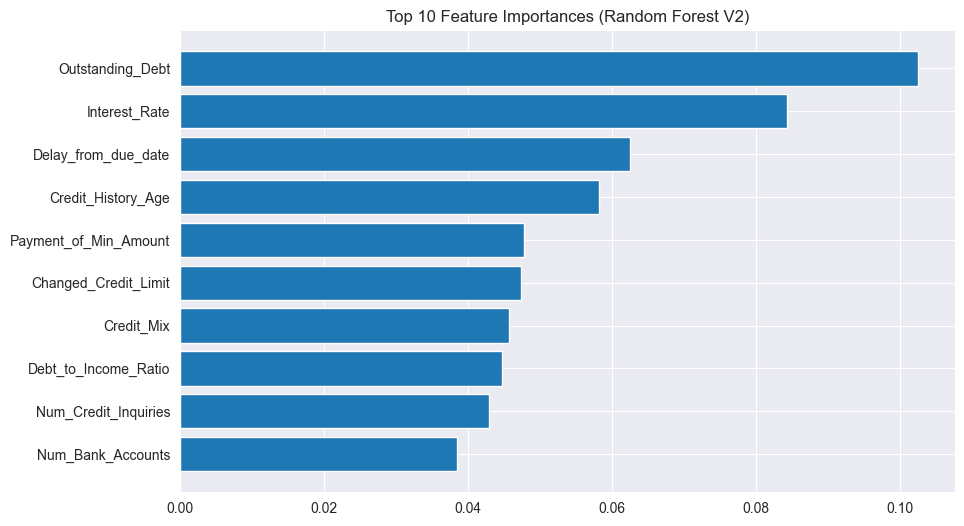

In [205]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_v2['feature'][:10], feat_imp_v2['importance'][:10]) # топ 10
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (Random Forest V2)')
plt.show()

Да, топ поменялся, но Outstanding_Debt так и не сместили с 1 места, тем не менее, Interest_Rate оказал существенное влияние, как выяснилось.

Клянусь, я не специально его убрал для 1 этапа)

Но модель не оценила особо типы займа, хотя они делятся по рискам

### XGBoost

In [195]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_inner_v2)
y_val_encoded = label_encoder.transform(y_val_v2)



In [203]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_v2),  # тот же препроцессор, что и для RF
    ('classifier', XGBClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=4,
        eval_metric='mlogloss',
        learning_rate=0.1
    ))
])

xgb_pipeline.fit(X_train_inner_v2, y_train_encoded)

y_pred_xgb_encoded = xgb_pipeline.predict(X_val_v2)
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)

f1_xgb = f1_score(y_val_v2, y_pred_xgb, average='macro')
print(f"XGBoost F1-macro: {f1_xgb:.4f}")
print("\n=== XGBoost Classification Report ===")
print(classification_report(y_val_v2, y_pred_xgb))

XGBoost F1-macro: 0.6781

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

        Good       0.58      0.64      0.61      5349
        Poor       0.73      0.63      0.68      8699
    Standard       0.73      0.76      0.75     15952

    accuracy                           0.70     30000
   macro avg       0.68      0.68      0.68     30000
weighted avg       0.71      0.70      0.70     30000



ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['Good' 'Poor' 'Standard']

Чувствую, что с этой ошибкой будет много возни, а я хочу спать(

Выше fix

Касательно XGBoost, возможно, я недостаточно опытен, чтобы работать с таким мощным инструментом, та же самая настройка гиперпараметров, тюнинг.

Тем не менее, не всегда градиентный бустинг может решать подобные задачи. Такое исследование показывает, что нет одного МЕГААА, ахахах, инструмента для решения всех задач.

Слышал ещё про RandomizedSearchCV, возможно это потенциальная точка роста.

### Выводы. Эпилог

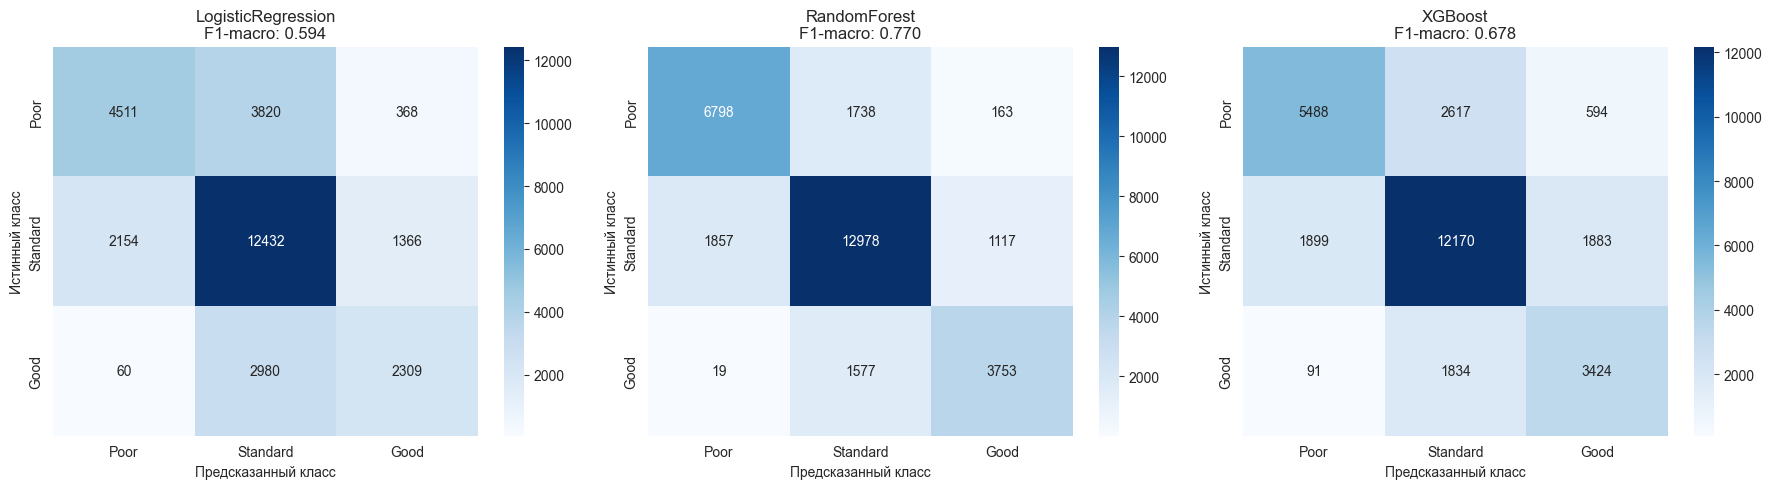

In [206]:
labels = ['Poor', 'Standard', 'Good']  # порядок как в данных

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (y_pred, title) in enumerate(zip([y_pred_baseline_v2, y_pred_rf_v2, y_pred_xgb],
                                       ['LogisticRegression', 'RandomForest', 'XGBoost'])):
    cm = confusion_matrix(y_val_v2, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_title(f'{title}\nF1-macro: {f1_score(y_val_v2, y_pred, average="macro"):.3f}')
    axes[i].set_ylabel('Истинный класс')
    axes[i].set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()

In [207]:
def get_class_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'F1-Poor': report['Poor']['f1-score'],
        'F1-Standard': report['Standard']['f1-score'],
        'F1-Good': report['Good']['f1-score'],
        'F1-macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }

results = {
    'LogisticRegression': get_class_f1(y_val_v2, y_pred_baseline_v2),
    'RandomForest': get_class_f1(y_val_v2, y_pred_rf_v2),
    'XGBoost': get_class_f1(y_val_v2, y_pred_xgb)
}

df_results = pd.DataFrame(results).T
print(df_results.round(3))

                    F1-Poor  F1-Standard  F1-Good  F1-macro  Accuracy
LogisticRegression    0.585        0.707    0.492     0.594     0.642
RandomForest          0.783        0.805    0.723     0.770     0.784
XGBoost               0.678        0.747    0.609     0.678     0.703


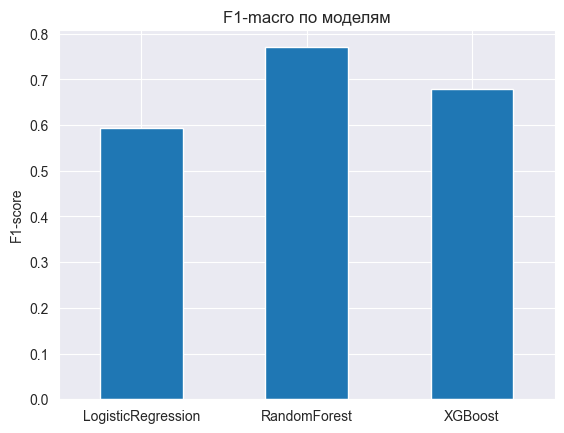

In [208]:
df_results['F1-macro'].plot(kind='bar', title='F1-macro по моделям', ylabel='F1-score')
plt.xticks(rotation=0)
plt.show()

#### Да, возможно не идеально, но в машинном обучение не бывает "ИДЕАЛЬНО"

Тем не менее, в этом исследовании был найден лучший метод для данной задачи классификации.

Random Forest лучше предсказывает чем LogReg 40%, точность выше на 30%

> ##### Может показаться, что 2 этап с улучшенными данными особо не влияет, но на самом деле прирост составил сумасшедшие 1,3%
> ##### Ну а если серьёзно, то просто не хватило нормальных данных, датасет с Kaggle очень плохо реализован даже как тренировочный, слишком нереалистичные данные, очень много несоответствий. 
> ##### Эх, получить бы реальный датасет Сбера или ВТБ

В целом если смотреть на Confusion matrix, то можем понять, что и пропусков у RF меньше всего,

но его тянет всё равно немного на standard, да, бывает, но опять же, это возможно максимально возможный результат, я считаю, что модель имеет смысл.